# 400V voltage sensor

In [1]:
# imPORT LIBRARIES 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import pi, sqrt
import handcalcs.render
import pandas as pd
import json 
# !pip install handcalcs

In [2]:
# CONFIGURATIONS
#help(handcalcs.set_option)
handcalcs.set_option("latex_block_start", "$")
handcalcs.set_option("latex_block_end", "$")
handcalcs.set_option("math_environment_end", "aligned")
handcalcs.set_option("use_scientific_notation",True)

In [3]:
with open("../01_llc_tank/04_outputs/inp_datas.json", "r", encoding="utf-8") as f:
    inp_datas = json.load(f)
print("Input datas:")
print("="*20)
display(inp_datas)

with open("../01_llc_tank/04_outputs/out_results.json", "r", encoding="utf-8") as f:
    out_datas = json.load(f)
print("Output datas:")
print("="*20)
display(out_datas)


# Load variables 
for key, value in inp_datas.items():
    globals()[key] = value
for key, value in out_datas.items():
    globals()[key] = value

Input datas:


{'V_In_min': 360.0,
 'V_In_nom': 380.0,
 'V_In_max': 400.0,
 'Vo_min': 42.0,
 'Vo_nom': 48.0,
 'Vo_max': 54.0,
 'Power': 1200.0,
 'f_nom': 100000.0}

Output datas:


{'Lnc': 3.0,
 'Qec': 0.55,
 'Cr_nF': 116.209,
 'n': 4.0,
 'Lr_uH': 21.797,
 'Lm_uH': 65.392,
 'fsw_min': 60170.0,
 'fsw_max': 156220.0,
 'Im_rms': 6.992,
 'Io': 25.0,
 'Ioe_rms': 7.636,
 'Ios_rms': 30.545,
 'Ir_rms': 10.354,
 'L_second_uH': 4.087,
 'Re_nom': 24.901,
 'Re_110': 22.637,
 'Cr': 1.16209e-07,
 'Lr': 2.1796999999999998e-05,
 'Lm': 6.539199999999999e-05}

In [152]:
1200*1.2/300

4.8

## Inputs and claculated parameters

In [9]:
#500V => 1V
#Input 100k to 1Mohm 
# 1/500=0.002
# 1/(100*5)=0.002
# 5 of 100k and one of 1k


In [59]:
%%render
N= 5
Rh=100e3 # ohm 
Rm=1e3 # ohm 
Req= Rh*N+Rm
R_input = Req /1e3 # kOhm
Vmax = 500
Imax= Vmax/Req
Pmax_Rh = Rh*Imax**2 # W
Pmax_Rm = Rm*Imax**2 # W

<IPython.core.display.Latex object>

### 100kOhm 

https://www.mouser.fr/ProductDetail/Vishay-Beyschlag/MCA1206ME1003BP500?qs=sGAEpiMZZMtlubZbdhIBINZyO39%252BOXIfkCwW9NuemNY%3D


MCA1206ME1003BP500

https://www.vishay.com/docs/28952/mcr0201at-mca1206at.pdf

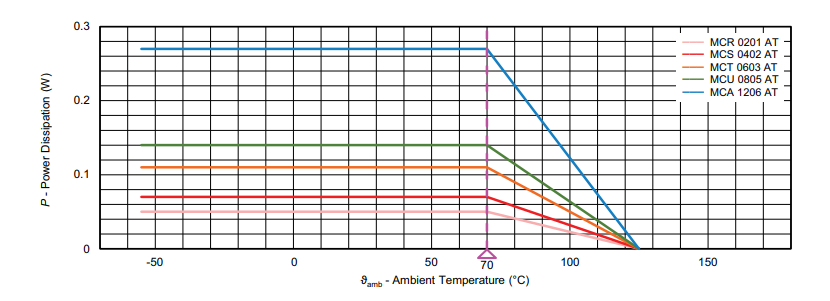

In [19]:
# for 100mW the max ambiant temp will be 110°C ==> ok 

### 1kOhm

https://www.mouser.fr/ProductDetail/SEI-Stackpole/RNCE1206BTE1K00?qs=sGAEpiMZZMtlubZbdhIBIGfmJML7fLMVTB3f79MD%2FW4%3D

RNCE1206BTE1K00

https://www.mouser.fr/datasheet/2/385/SEI_RNCE-3567365.pdf

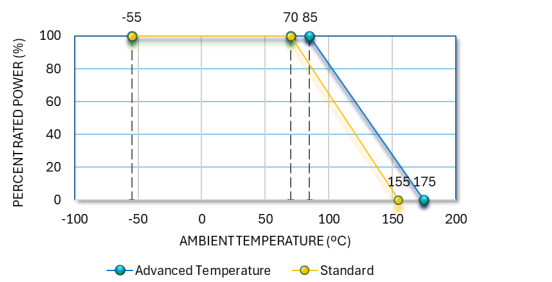

In [104]:
#  a lot of margin 

In [102]:
#%%render 
Ratio = Rm/(Rm+Rh*N)
Vref = 1100 # nominal 
Nb_bits = 2**12-1
for v in [200,300,400,500]:
    vout = Ratio*v*1000
    adc = int(Nb_bits*vout/Vref )
    print(f" Vin = {v}, Vout= {vout:.1f} mV, Numeric out of ADC = {adc}")

 Vin = 200, Vout= 399.2 mV, Numeric out of ADC = 1486
 Vin = 300, Vout= 598.8 mV, Numeric out of ADC = 2229
 Vin = 400, Vout= 798.4 mV, Numeric out of ADC = 2972
 Vin = 500, Vout= 998.0 mV, Numeric out of ADC = 3715


In [42]:
%%render 
Cp_nF= 100 # nF

<IPython.core.display.Latex object>

$$
H(j\omega) = \frac{Z_b}{R_h + Z_b}
$$

where

$$
Z_b = \frac{R_m}{1 + j\omega R_m C}
$$

Substituting:

$$
H(j\omega) = \frac{\frac{R_m}{1 + j\omega R_m C}}{R_h + \frac{R_m}{1 + j\omega R_m C}}
$$

Multiply numerator and denominator by $(1 + j\omega R_m C)$:

$$
H(j\omega) = \frac{R_m}{R_h + R_m + j\omega R_h R_m C}
$$

Factor $(R_h + R_m)$ from the denominator:

$$
H(j\omega) = \frac{R_m}{R_h + R_m} \cdot \frac{1}{1 + j\omega \frac{R_h R_m C}{R_h + R_m}}
$$


In [56]:
%%render 
C=Cp_nF*1e-9
w_0=(Rh+Rm)/(Rh*Rm*C) # rad/s
F_0= w_0/(2*pi) # Hz
To_us=1e6/w_0 # µs

<IPython.core.display.Latex object>

The voltage across a discharging capacitor through a resistor follows the exponential decay:

$$
V(t) = V_0 \, e^{-\frac{t}{R C}}
$$

where:  
- \(V_0\) = initial voltage (e.g., HV bus voltage)  
- \(V(t)\) = voltage at time \(t\)  
- \(R\) = bleed resistor value  
- \(C\) = total capacitance  

---

**Goal:** Find \(R\) (or \(C\)) such that

$$
V(t) \leq V_s
$$

where \(V_s\) is the safety voltage (e.g., 60 V) at time \(t = 5\,\text{s}\).

---

Rearranging the equation:

$$
V_s \geq V_0 \, e^{-\frac{t}{R C}}
$$

Divide both sides by \(V_0\):

$$
\frac{V_s}{V_0} \geq e^{-\frac{t}{R C}}
$$

Take the natural logarithm:

$$
\ln\left(\frac{V_s}{V_0}\right) \geq -\frac{t}{R C}
$$

Multiply both sides by \(-1\) (flip inequality):

$$
-\ln\left(\frac{V_s}{V_0}\right) \leq \frac{t}{R C}
$$

Solve for \(R\):

$$
R \leq \frac{t}{C \cdot \left(-\ln\left(\frac{V_s}{V_0}\right)\right)} = \frac{t}{C \cdot \ln\left(\frac{V_0}{V_s}\right)}
$$

---

**Alternatively, solving for \(C\):**

$$
C \leq \frac{t}{R \cdot \ln\left(\frac{V_0}{V_s}\right)}
$$

---

++> Summary:

To ensure the voltage drops below \(V_s\) at time \(t\), the resistor and capacitor must satisfy:

$$
R \leq \frac{t}{C \cdot \ln\left(\frac{V_0}{V_s}\right)}
\quad\text{or}\quad
C \leq \frac{t}{R \cdot \ln\left(\frac{V_0}{V_s}\right)}
$$

---

++>  Example:

- \(V_0 = 400\,\text{V}\)  
- \(V_s = 60\,\text{V}\)  
- \(t = 5\,\text{s}\)  
- Given \(C\), find \(R\):

$$
R \leq \frac{5}{C \cdot \ln\left(\frac{400}{60}\right)} = \frac{5}{C \cdot \ln(6.67)} \approx \frac{5}{C \cdot 1.90}
$$

or given \(R\), find \(C\):

$$
C \leq \frac{5}{R \cdot 1.90}
$$


In [67]:
from math import log

In [70]:
%%render 
# ISO 6469-3 (Electric Road Vehicles — Safety)
# 60V => 5s
Vmax = 500 # V
Vlim = 60
t_target = 5 
Req
Clim_uF = 1e6*t_target/(Req*log(Vmax/Vlim))

<IPython.core.display.Latex object>

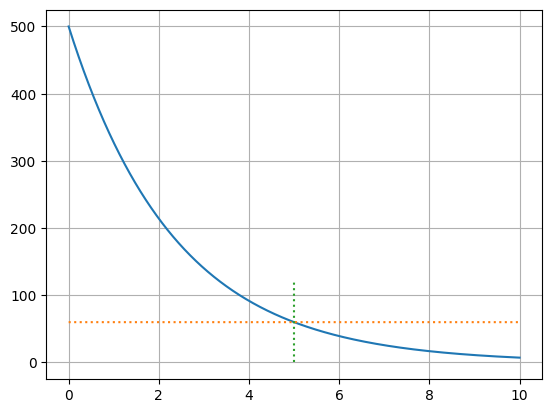

In [84]:
t= np.arange(0,10,1e-3)
V = Vmax*np.exp(-t/(Req*(Clim_uF*1e-6)))
plt.plot(t, V)
plt.plot(t,[Vlim ]*len(t), linestyle = 'dotted')
plt.plot([t_target, t_target],[0,Vlim*2 ], linestyle = 'dotted')
plt.grid()

### Precision

In [101]:
%%render 
Tolerance_Rm= 0.1/100
Tolerance_Rh= 0.1/100
Ratio_nom = 1000*Rm/(Rm+Rh*N) # milli 
Ratio_min = 1000*Rm*(1-Tolerance_Rm)/(Rm*(1-Tolerance_Rm)+Rh*(1+Tolerance_Rh)*N) # milli

Ratio_max = 1000*Rm*(1+Tolerance_Rm)/(Rm*(1+Tolerance_Rm)+Rh*(1-Tolerance_Rh)*N) # milli

error_P = 100*(Ratio_max -Ratio_nom) /Ratio_nom # %
error_N = 100*(Ratio_min -Ratio_nom) /Ratio_nom # %
error_P # '%
error_N # %

<IPython.core.display.Latex object>

1. Quantization Error
Due to finite resolution—difference between actual input and closest discrete output level.

Typically ±0.5 LSB.

In [127]:
%%render 
Vref = 1100 # nominal 
Nbits= 12
Max_error_quantization = Vref / (2**Nbits -1) # mV 

<IPython.core.display.Latex object>

In [128]:
#%%render 
Ratio = Rm/(Rm+Rh*N)
Vref = 1100 # nominal 
Nb_bits = 2**12-1
for v in [200,300,400,500]:
    vout = Ratio*v*1000
    adc = int(Nb_bits*vout/Vref )
    error_quant=100*Max_error_quantization/vout
    print(f" Vin = {v}, Vout= {vout:.1f} mV, Numeric out of ADC = {adc}, error quant {error_quant:.2f}%")

 Vin = 200, Vout= 166.5 mV, Numeric out of ADC = 619, error quant 0.16%
 Vin = 300, Vout= 249.8 mV, Numeric out of ADC = 929, error quant 0.11%
 Vin = 400, Vout= 333.1 mV, Numeric out of ADC = 1239, error quant 0.08%
 Vin = 500, Vout= 416.3 mV, Numeric out of ADC = 1549, error quant 0.06%


In [ ]:
# WE MUST MAKE QUALIBRATION OF OTHER ERROR 

| Error Type     | Typical ± Error (LSB) | Approx. Voltage (mV) @1.1V ref |
| -------------- | --------------------- | ------------------------------ |
| Quantization   | ±0.5                  | ±0.27                          |
| Vref variation | ±55 mV (5%)           | ±200 LSB (approx)              |
| Offset         | ±2                    | ±0.54                          |
| Gain error     | ±1–5%                 | ±11–55 mV                      |
| INL/DNL        | ±1–5                  | ±0.27–1.35                     |
| Noise (RMS)    | 2–4                   | 0.54–1.1                       |


| Error Type                         | Value/Range from Official Docs                                              | Document / Section / Page / URL                                             | Notes                                                         |
| ---------------------------------- | --------------------------------------------------------------------------- | --------------------------------------------------------------------------- | ------------------------------------------------------------- |
| **Quantization Error**             | ±0.5 LSB (definition, implicit from ADC resolution)                         | ESP32-S3 Technical Reference Manual (TRM), ADC chapter                      | Resolution: 12-bit (p. 126+ TRM)                              |
| **Reference Voltage Error (Vref)** | Internal reference nominal 1.1 V, ±5% typical variation mentioned           | ESP32-S3 Datasheet v1.1 (April 2022), Section 5.9 ADC Characteristics, p.21 | See section “ADC Reference voltage” and “ADC characteristics” |
| **Offset Error**                   | No explicit offset error value given, but calibration APIs exist            | ESP32-S3 Technical Reference Manual, ADC chapter, Calibration section       | Calibration APIs imply offset exists; no numeric spec         |
| **Gain Error**                     | No numeric gain error spec found directly; expected included in calibration | No explicit numeric gain error spec in datasheet or TRM                     | You need to measure or calibrate                              |
| **INL/DNL**                        | Mentioned qualitatively; no numeric INL/DNL specs in datasheet              | ESP32-S3 Technical Reference Manual, ADC chapter                            | Non-linearity mentioned but no detailed figures               |
| **Noise**                          | Noise level discussed qualitatively; no numeric noise figure given          | ESP32-S3 Datasheet, Section 5.9 ADC Characteristics                         | “ADC noise performance varies with settings” but no numbers   |
| **Temperature Drift**              | No explicit temperature drift spec for ADC error                            | No data found in datasheet or TRM                                           | Only general IC temp specs available                          |
| **Sampling Error**                 | Not explicitly specified                                                    | No data found in datasheet or TRM                                           | Assumed standard SAR ADC behavior                             |
| **Clock Jitter**                   | Not specified                                                               | No data found                                                               | Controlled by internal clock design                           |


# 48 v OUTPUT

In [135]:
print(V_In_max, Vo_max)
a = 500/V_In_max
Va= a*Vo_max
Va

400.0 54.0


67.5

In [133]:
# 67.5<=>1

In [137]:
Va*1/(1+66.5)

1.0

16.625

In [148]:
%%render
N= 1
Rh=66.5e3 # ohm 
Rm=1000 # ohm 
Req= Rh*N+Rm
R_input = Req /1e3 # kOhm
Vmax = Va
Imax= Vmax/Req
Pmax_Rh = Rh*Imax**2 # W
Pmax_Rm = Rm*Imax**2 # W

<IPython.core.display.Latex object>

#### 66.5k

https://www.mouser.fr/ProductDetail/YAGEO/RT1206BRD0766K5L?qs=sGAEpiMZZMvdGkrng054t98Xz4DA4UW4zTOBT3kE8YE%3D

RT1206BRD0766K5L


https://www.mouser.fr/datasheet/2/447/PYu_RT_1_to_0_01_RoHS_L_12-3003070.pdf


USE AMC3330


https://www.ti.com/lit/ds/symlink/amc3330.pdf?ts=1754805020623

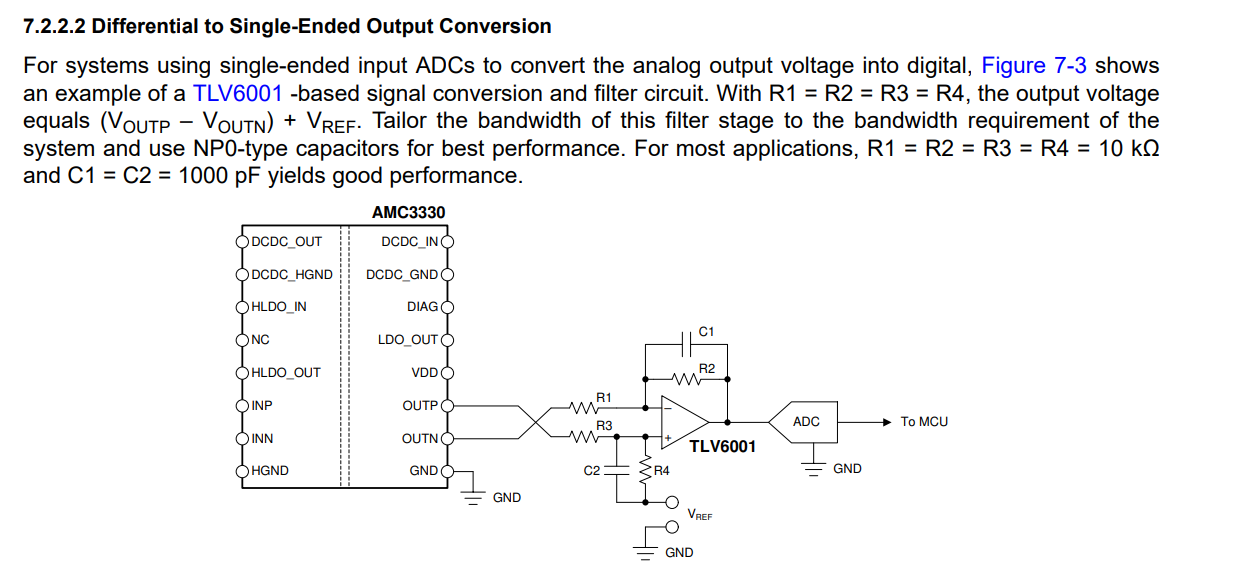

https://www.ti.com/lit/ds/symlink/tlv6001.pdf?ts=1754837173579&ref_url=https%253A%252F%252Fwww.mouser.fr%252F
https://www.mouser.fr/ProductDetail/Texas-Instruments/TLV6001UIDBVR?qs=8N88piwwHEgntIgM8jjJ5Q%3D%3D



https://www.ti.com/lit/ds/symlink/amc3330.pdf?ts=1754805020623

https://www.mouser.fr/ProductDetail/Texas-Instruments/AMC3330DWER?qs=zW32dvEIR3u5qLqnY17MoA%3D%3D



all can be power with 5V 

potensiometre de precision 


https://fr.aliexpress.com/item/1005005920085508.html

# ref 

https://www.mouser.fr/ProductDetail/Analog-Devices/LT6654BIS6-3.3TRMPBF?qs=BZBei1rCqCCqaYd0O2NHKg%3D%3D

https://www.mouser.fr/datasheet/2/609/lt6654-3124249.pdf

# Inp current sensor

In [200]:
%%render
V_In_min
V_In_max
Power
I_o_max = Power /V_In_min
I_o_maxMargin = 1.25*I_o_max  # A

<IPython.core.display.Latex object>

In [201]:
%%render
Sensitivity= 185  # mV/A
Vout_mV=I_o_maxMargin*Sensitivity

<IPython.core.display.Latex object>

https://eu.mouser.com/ProductDetail/Broadcom-Avago/ACHS-7121-000E?qs=w%2Fv1CP2dgqo3exDSmSklAg%3D%3D


ACHS-7121-000E


https://eu.mouser.com/datasheet/2/678/avgo_s_a0010841446_1-2290987.pdf


**OR OR OROROROR** 
https://eu.mouser.com/ProductDetail/ACEINNA/MCR1101-5-5?qs=0lSvoLzn4L8mQTSrg%2F9DUA%3D%3D


MCR1101-5-5


https://eu.mouser.com/datasheet/2/940/6020-1101-01_RevE_MCR1101_20190627-1622836.pdf

In [203]:
%%render
Sensitivity= 400  # mV/A
Vout_mV=I_o_maxMargin*Sensitivity

<IPython.core.display.Latex object>

In [204]:
%%render 
# diff 
Vdd = 5
R2= 10e3
R1= 20e3
R3= 40e3
R4= 10e3
rat1= R2/R1
rat2= R4/R3
vouti = Vout_mV/1000
Vdd= 5
vout = vouti + Vdd/2
vout_diff = rat1*vout -rat2*Vdd

<IPython.core.display.Latex object>

# oUT current sensor

In [205]:
%%render
Vo_min
Vo_max
Power
I_o_max = Power /Vo_min
I_o_maxMargin = 1.25*I_o_max  # A

<IPython.core.display.Latex object>

In [206]:
%%render
Sensitivity= 40 # mV/A
Vout_mV=I_o_maxMargin*Sensitivity

<IPython.core.display.Latex object>

MCR1101-50-5

https://eu.mouser.com/datasheet/2/940/6020-1101-01_RevE_MCR1101_20190627-1622836.pdf

https://eu.mouser.com/ProductDetail/ACEINNA/MCR1101-50-5?qs=0lSvoLzn4L865aaRCd1YBg%3D%3D

In [207]:
50/35, 5/4.1

(1.4285714285714286, 1.2195121951219514)

In [208]:
%%render 
# diff 
Vdd = 5
R2= 10e3
R1= 20e3
R3= 40e3
R4= 10e3
rat1= R2/R1
rat2= R4/R3
vouti = Vout_mV/1000
Vdd= 5
vout = vouti + Vdd/2
vout_diff = rat1*vout -rat2*Vdd

<IPython.core.display.Latex object>

# 12V to 3.3V, i must found 5V 

mouser.fr/datasheet/2/115/diodes%20inc._ap1509-1163839.pdf

# 12v to 5v 1A

https://www.mouser.fr/ProductDetail/Microchip-Technology/LM2575-5.0WU-TR?qs=Y3Q3JoKAO1SZ99CofPdz5Q%3D%3D


LM2575-5.0WU-TR


https://www.mouser.fr/datasheet/2/268/lm2575-3445183.pdf

# comparator

| Comparator       | Channels | Output Type          | Supply & Pull-Up | Speed     | Price\*               | Notes                                       |
| ---------------- | -------- | -------------------- | ---------------- | --------- | --------------------- | ------------------------------------------- |
| **LM393 (ST)**   | 2        | Open-collector       | 2–36 V; 3.3 V OK | \~1.3 µs  | \~€0.17               | Extremely low-cost, widely used             |
| **LM339**        | 4        | Open-collector       | 3 V+             | Similar   | Very low (comparable) | Quad package, excellent value               |
| **LM2903M/N**    | 2        | Open-collector       | \~2 V+           | \~1.5 µs? | €1.10–\$1.75          | Great dual comparator option (Mouser stock) |
| **TLV902x/903x** | 2 or 4   | Open-drain/push-pull | 1.65–5.5 V       | \~100 ns  | Higher                | Superior speed, for demanding use           |
